BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. 

The aim of this project is to build a predictive model and find out the sales of each product at a particular store.

In [2]:
## load packages
library(data.table) # used for reading and manipulation of data
library(dplyr)      # used for data manipulation and joining
library(ggplot2)    # used for ploting 
library(caret)      # used for modeling
library(corrplot)   # used for making correlation plot
# install.packages('xgboost', repos='http://cran.us.r-project.org')
library(xgboost)    # used for building XGBoost model
library(cowplot)    # used for combining multiple plots 

In [3]:
## read datasets using fread function in the data.table R package
train = fread("Train.csv")
test = fread("Test.csv")
submission = fread("SampleSubmission.csv")
head(train)

Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
FDA15,9.300,Low Fat,0.01604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.920,Regular,0.01927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.500,Low Fat,0.01676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.200,Regular,0.00000000,Fruits and Vegetables,182.0950,OUT010,1998,,Tier 3,Grocery Store,732.3800
NCD19,8.930,Low Fat,0.00000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
FDP36,10.395,Regular,0.00000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088


In [4]:
summary(train)

 Item_Identifier     Item_Weight     Item_Fat_Content   Item_Visibility  
 Length:8523        Min.   : 4.555   Length:8523        Min.   :0.00000  
 Class :character   1st Qu.: 8.774   Class :character   1st Qu.:0.02699  
 Mode  :character   Median :12.600   Mode  :character   Median :0.05393  
                    Mean   :12.858                      Mean   :0.06613  
                    3rd Qu.:16.850                      3rd Qu.:0.09459  
                    Max.   :21.350                      Max.   :0.32839  
                    NA's   :1463                                         
  Item_Type            Item_MRP      Outlet_Identifier 
 Length:8523        Min.   : 31.29   Length:8523       
 Class :character   1st Qu.: 93.83   Class :character  
 Mode  :character   Median :143.01   Mode  :character  
                    Mean   :140.99                     
                    3rd Qu.:185.64                     
                    Max.   :266.89                     
                

In [6]:
## train data column names
names(train)

## test data column names
names(test)

[1] "Item_Identifier"           "Item_Weight"              
 [3] "Item_Fat_Content"          "Item_Visibility"          
 [5] "Item_Type"                 "Item_MRP"                 
 [7] "Outlet_Identifier"         "Outlet_Establishment_Year"
 [9] "Outlet_Size"               "Outlet_Location_Type"     
[11] "Outlet_Type"               "Item_Outlet_Sales"

[1] "Item_Identifier"           "Item_Weight"              
 [3] "Item_Fat_Content"          "Item_Visibility"          
 [5] "Item_Type"                 "Item_MRP"                 
 [7] "Outlet_Identifier"         "Outlet_Establishment_Year"
 [9] "Outlet_Size"               "Outlet_Location_Type"     
[11] "Outlet_Type"

> We can see the target var 'Item_Outlet_Sales' is missing in the test set for the obvious reason.

> This is what we are going to predict.

In [7]:
## structure of train data
str(train)
dim(train)

Classes 'data.table' and 'data.frame':	8523 obs. of  12 variables:
 $ Item_Identifier          : chr  "FDA15" "DRC01" "FDN15" "FDX07" ...
 $ Item_Weight              : num  9.3 5.92 17.5 19.2 8.93 ...
 $ Item_Fat_Content         : chr  "Low Fat" "Regular" "Low Fat" "Regular" ...
 $ Item_Visibility          : num  0.016 0.0193 0.0168 0 0 ...
 $ Item_Type                : chr  "Dairy" "Soft Drinks" "Meat" "Fruits and Vegetables" ...
 $ Item_MRP                 : num  249.8 48.3 141.6 182.1 53.9 ...
 $ Outlet_Identifier        : chr  "OUT049" "OUT018" "OUT049" "OUT010" ...
 $ Outlet_Establishment_Year: int  1999 2009 1999 1998 1987 2009 1987 1985 2002 2007 ...
 $ Outlet_Size              : chr  "Medium" "Medium" "Medium" "" ...
 $ Outlet_Location_Type     : chr  "Tier 1" "Tier 3" "Tier 1" "Tier 3" ...
 $ Outlet_Type              : chr  "Supermarket Type1" "Supermarket Type2" "Supermarket Type1" "Grocery Store" ...
 $ Item_Outlet_Sales        : num  3735 443 2097 732 995 ...
 - attr(*, ".i

[1] 8523   12

In [8]:
## structure of test data
str(test)
dim(test)

Classes 'data.table' and 'data.frame':	5681 obs. of  11 variables:
 $ Item_Identifier          : chr  "FDW58" "FDW14" "NCN55" "FDQ58" ...
 $ Item_Weight              : num  20.75 8.3 14.6 7.32 NA ...
 $ Item_Fat_Content         : chr  "Low Fat" "reg" "Low Fat" "Low Fat" ...
 $ Item_Visibility          : num  0.00756 0.03843 0.09957 0.01539 0.1186 ...
 $ Item_Type                : chr  "Snack Foods" "Dairy" "Others" "Snack Foods" ...
 $ Item_MRP                 : num  107.9 87.3 241.8 155 234.2 ...
 $ Outlet_Identifier        : chr  "OUT049" "OUT017" "OUT010" "OUT017" ...
 $ Outlet_Establishment_Year: int  1999 2007 1998 2007 1985 1997 2009 1985 2002 2007 ...
 $ Outlet_Size              : chr  "Medium" "" "" "" ...
 $ Outlet_Location_Type     : chr  "Tier 1" "Tier 2" "Tier 3" "Tier 2" ...
 $ Outlet_Type              : chr  "Supermarket Type1" "Supermarket Type1" "Grocery Store" "Supermarket Type1" ...
 - attr(*, ".internal.selfref")=<externalptr> 


[1] 5681   11

> Before we add the train and test sets to perform data wrangling, we must make sure that both the sets have the columns similarly named and equal in number.

In [9]:
## add Item_Outlet_Sales col to test data with missing values
test[,Item_Outlet_Sales := NA] 

# combining train and test datasets
combi = rbind(train, test) 
dim(combi)

[1] 14204    12

## EDA - Univariate

Warning message:
"Removed 2439 rows containing non-finite values (stat_bin)."

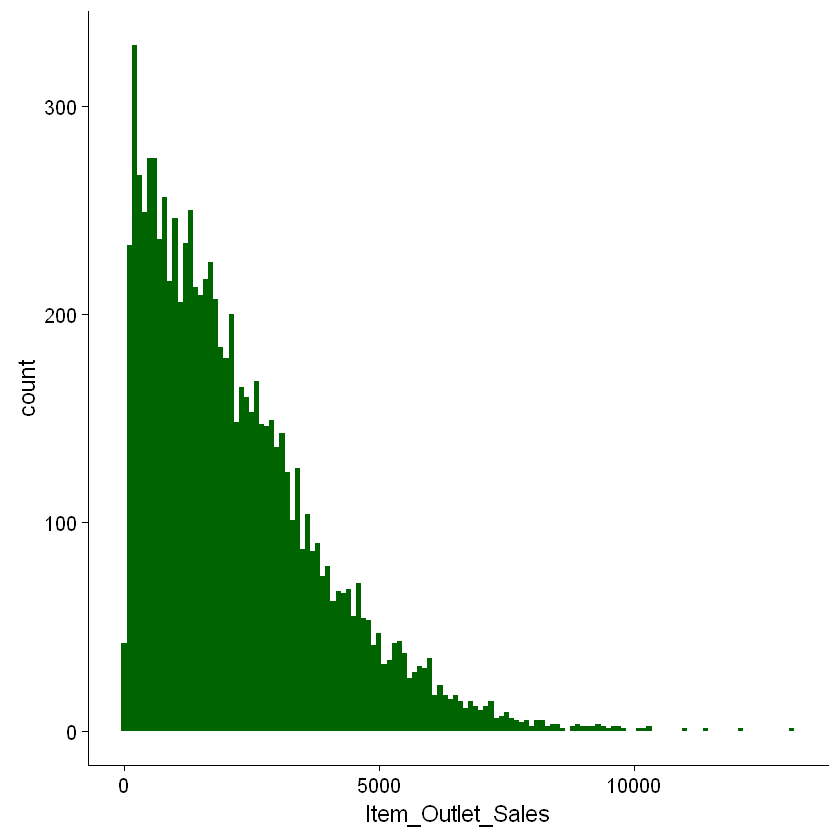

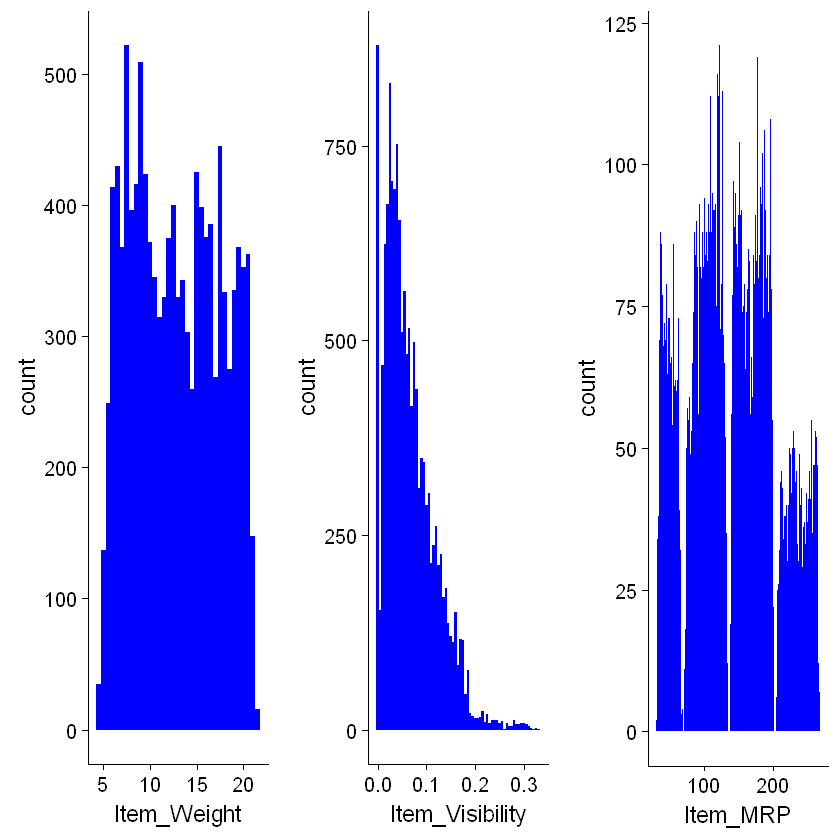

In [10]:
ggplot(train) + geom_histogram(aes(Item_Outlet_Sales), binwidth = 100, fill = "darkgreen") +
  xlab("Item_Outlet_Sales")


p1 = ggplot(combi) + geom_histogram(aes(Item_Weight), binwidth = 0.5, fill = "blue")

p2 = ggplot(combi) + geom_histogram(aes(Item_Visibility), binwidth = 0.005, fill = "blue")

p3 = ggplot(combi) + geom_histogram(aes(Item_MRP), binwidth = 1, fill = "blue")

plot_grid(p1, p2, p3, nrow = 1) # plot_grid() from cowplot package

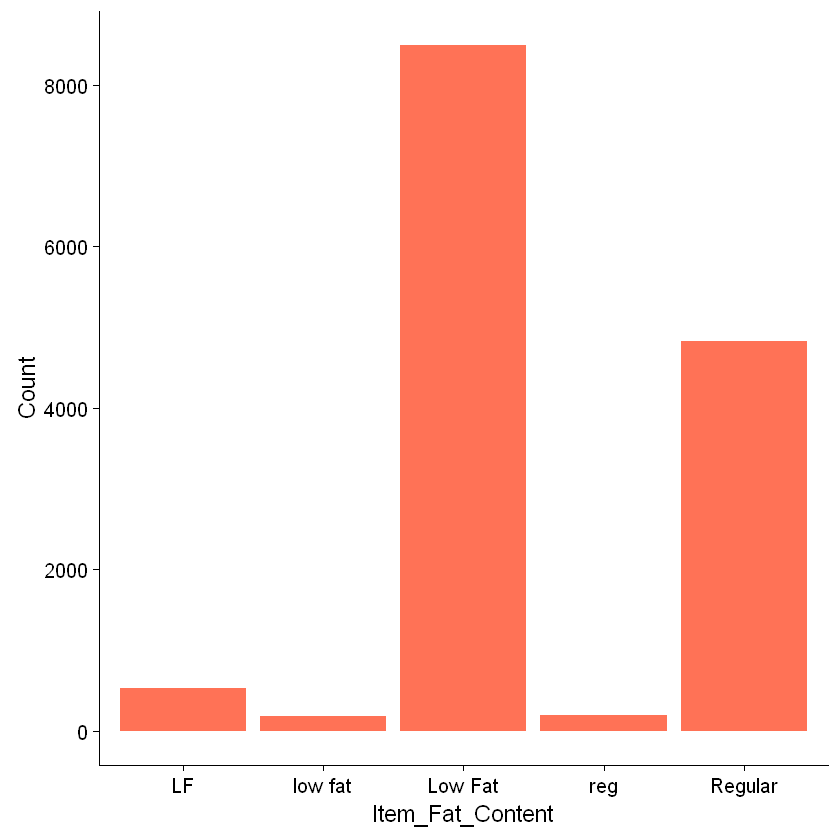

In [11]:
ggplot(combi %>% group_by(Item_Fat_Content) %>% summarise(Count = n())) + 
  geom_bar(aes(Item_Fat_Content, Count), stat = "identity", fill = "coral1")


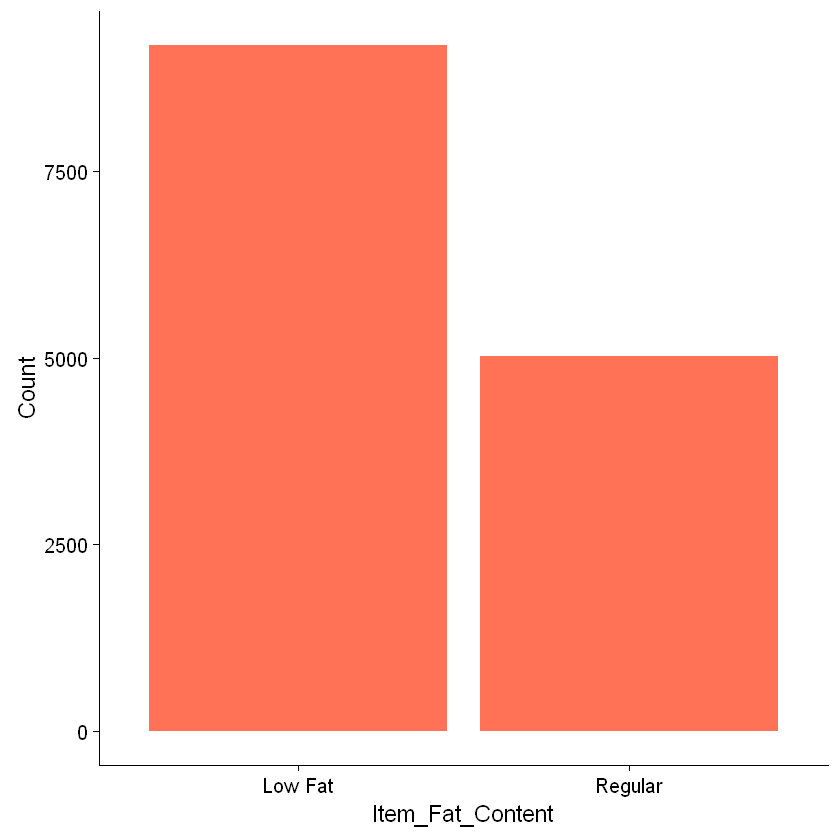

In [12]:
combi$Item_Fat_Content[combi$Item_Fat_Content == "LF"] = "Low Fat"
combi$Item_Fat_Content[combi$Item_Fat_Content == "low fat"] = "Low Fat"
combi$Item_Fat_Content[combi$Item_Fat_Content == "reg"] = "Regular"

ggplot(combi %>% group_by(Item_Fat_Content) %>% summarise(Count = n())) + 
  geom_bar(aes(Item_Fat_Content, Count), stat = "identity", fill = "coral1")

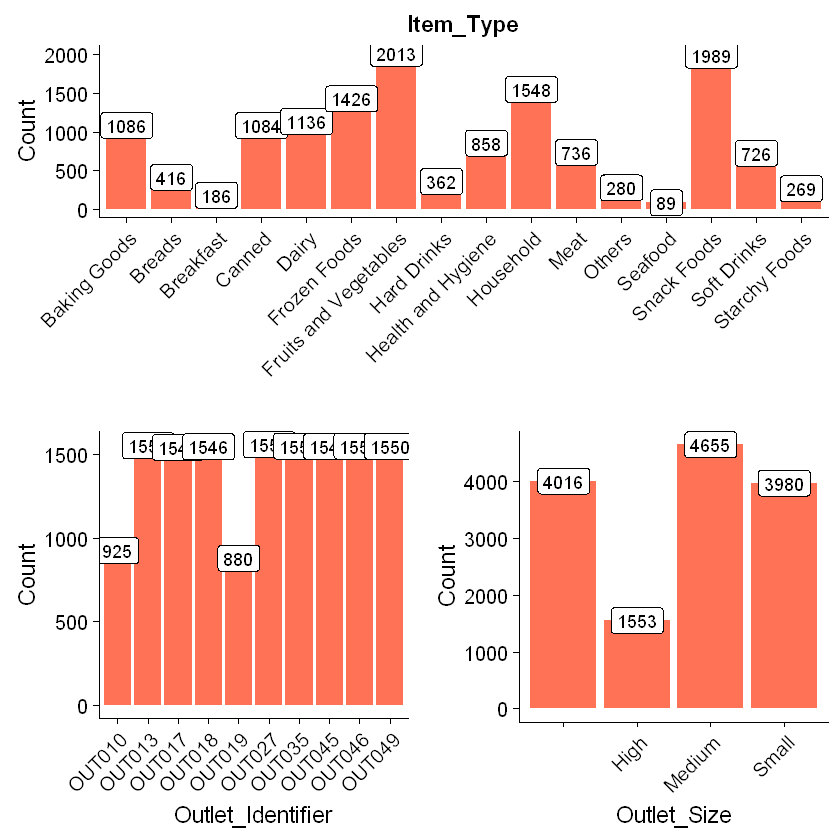

In [13]:
# plot for Item_Type
p4 = ggplot(combi %>% group_by(Item_Type) %>% summarise(Count = n())) + 
  geom_bar(aes(Item_Type, Count), stat = "identity", fill = "coral1") +
  xlab("") +
  geom_label(aes(Item_Type, Count, label = Count), vjust = 0.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  ggtitle("Item_Type")

# plot for Outlet_Identifier
p5 = ggplot(combi %>% group_by(Outlet_Identifier) %>% summarise(Count = n())) + 
  geom_bar(aes(Outlet_Identifier, Count), stat = "identity", fill = "coral1") +
  geom_label(aes(Outlet_Identifier, Count, label = Count), vjust = 0.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# plot for Outlet_Size
p6 = ggplot(combi %>% group_by(Outlet_Size) %>% summarise(Count = n())) + 
  geom_bar(aes(Outlet_Size, Count), stat = "identity", fill = "coral1") +
  geom_label(aes(Outlet_Size, Count, label = Count), vjust = 0.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

second_row = plot_grid(p5, p6, nrow = 1)

plot_grid(p4, second_row, ncol = 1)

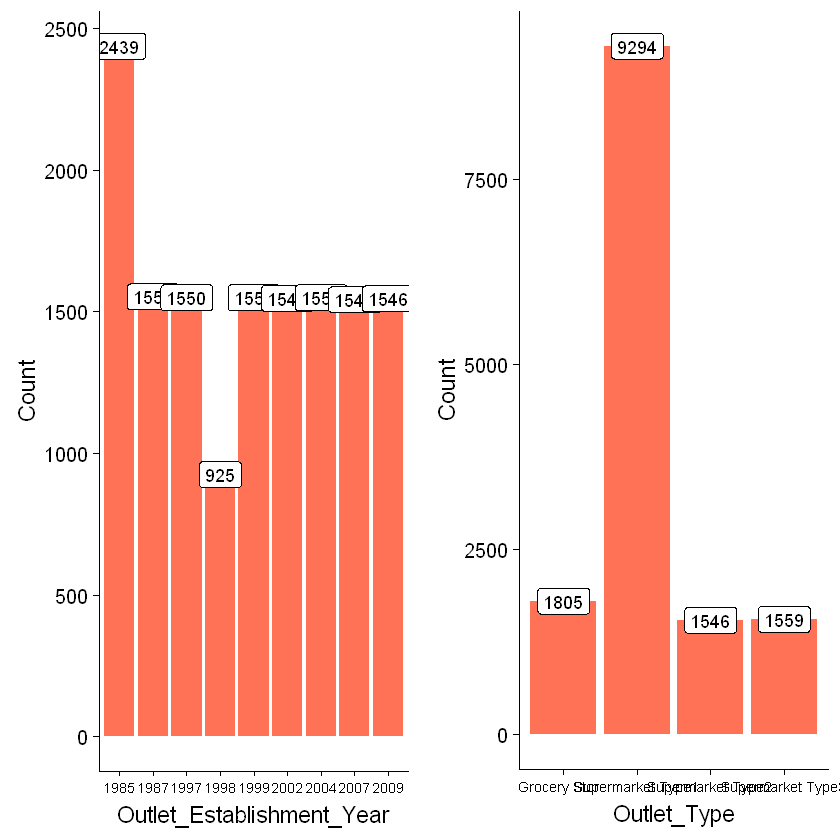

In [14]:
# plot for Outlet_Establishment_Year
p7 = ggplot(combi %>% group_by(Outlet_Establishment_Year) %>% summarise(Count = n())) + 
  geom_bar(aes(factor(Outlet_Establishment_Year), Count), stat = "identity", fill = "coral1") +
  geom_label(aes(factor(Outlet_Establishment_Year), Count, label = Count), vjust = 0.5) +
  xlab("Outlet_Establishment_Year") +
  theme(axis.text.x = element_text(size = 8.5))

# plot for Outlet_Type
p8 = ggplot(combi %>% group_by(Outlet_Type) %>% summarise(Count = n())) + 
  geom_bar(aes(Outlet_Type, Count), stat = "identity", fill = "coral1") +
  geom_label(aes(factor(Outlet_Type), Count, label = Count), vjust = 0.5) +
  theme(axis.text.x = element_text(size = 8.5))

# ploting both plots together
plot_grid(p7, p8, ncol = 2)

## EDA - Bivariate

Warning message:
"Removed 1463 rows containing missing values (geom_point)."

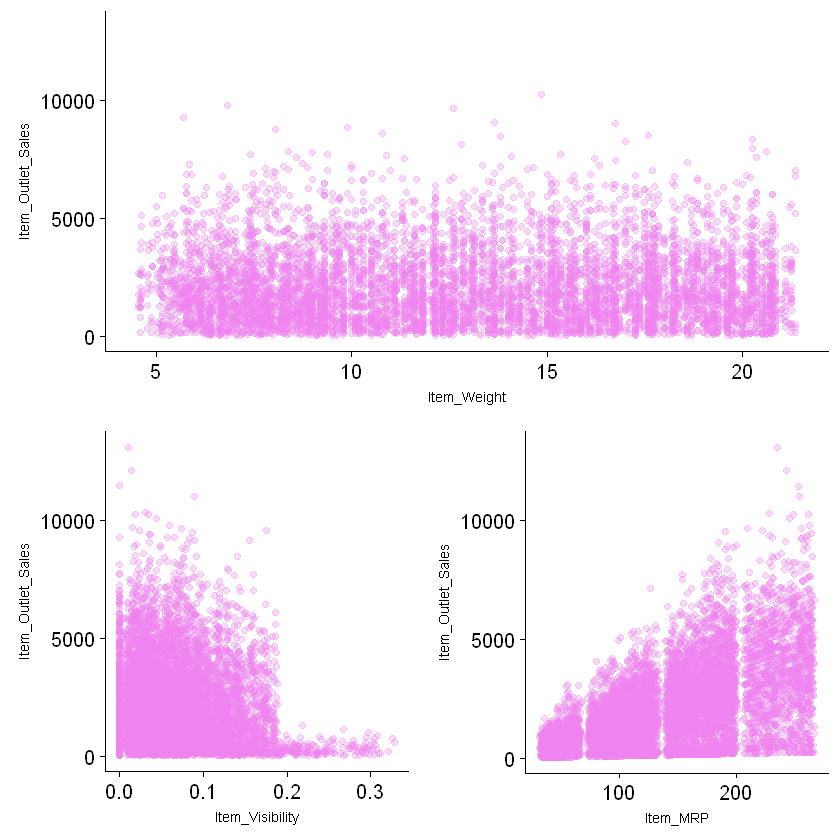

In [15]:
train = combi[1:nrow(train)]

# Item_Weight vs Item_Outlet_Sales
p9 = ggplot(train) + geom_point(aes(Item_Weight, Item_Outlet_Sales), colour = "violet", alpha = 0.3) +
     theme(axis.title = element_text(size = 8.5))

# Item_Visibility vs Item_Outlet_Sales
p10 = ggplot(train) + geom_point(aes(Item_Visibility, Item_Outlet_Sales), colour = "violet", alpha = 0.3) +
      theme(axis.title = element_text(size = 8.5))

# Item_MRP vs Item_Outlet_Sales
p11 = ggplot(train) + geom_point(aes(Item_MRP, Item_Outlet_Sales), colour = "violet", alpha = 0.3) +
      theme(axis.title = element_text(size = 8.5))

second_row_2 = plot_grid(p10, p11, ncol = 2)

plot_grid(p9, second_row_2, nrow = 2)

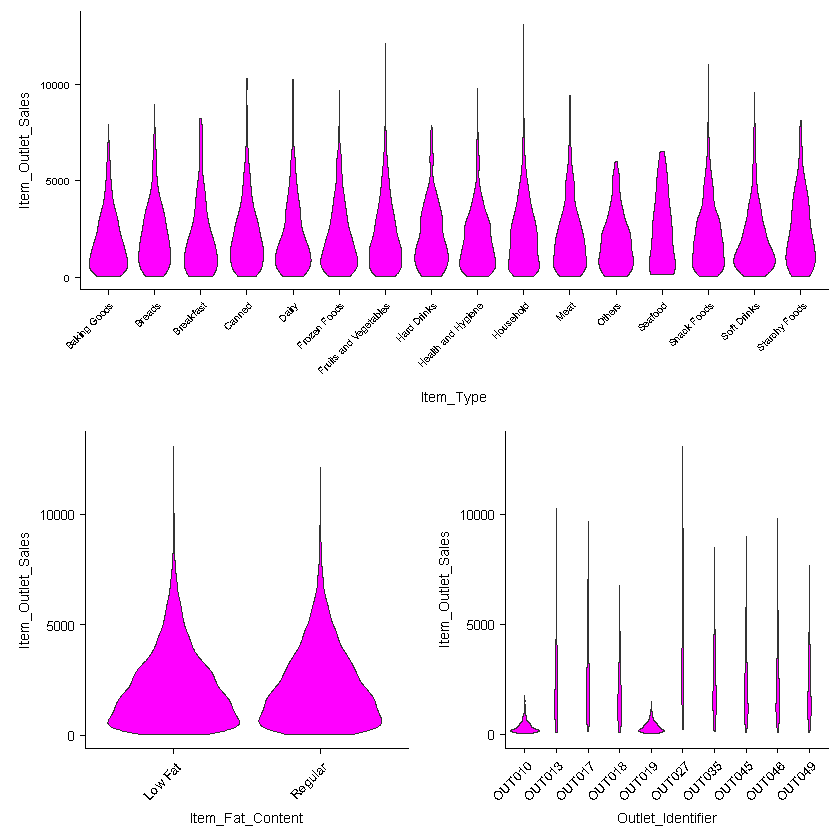

In [16]:
# Item_Type vs Item_Outlet_Sales
p12 = ggplot(train) + geom_violin(aes(Item_Type, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 6),
        axis.title = element_text(size = 8.5))

# Item_Fat_Content vs Item_Outlet_Sales
p13 = ggplot(train) + geom_violin(aes(Item_Fat_Content, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 8),
        axis.title = element_text(size = 8.5))

# Outlet_Identifier vs Item_Outlet_Sales
p14 = ggplot(train) + geom_violin(aes(Outlet_Identifier, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 8),
        axis.title = element_text(size = 8.5))

second_row_3 = plot_grid(p13, p14, ncol = 2)

plot_grid(p12, second_row_3, ncol = 1)

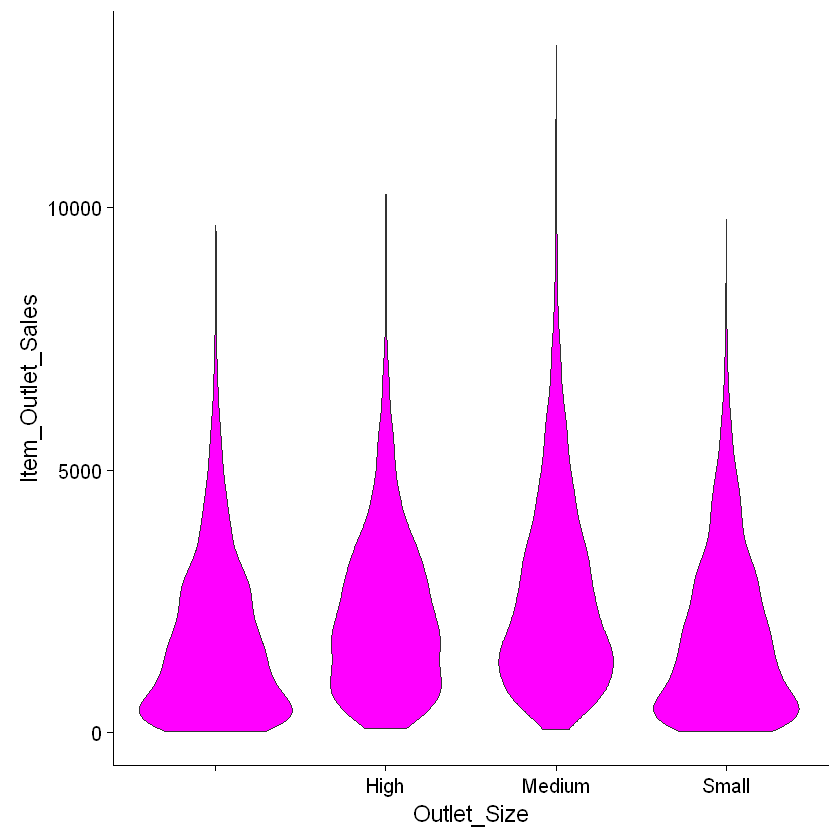

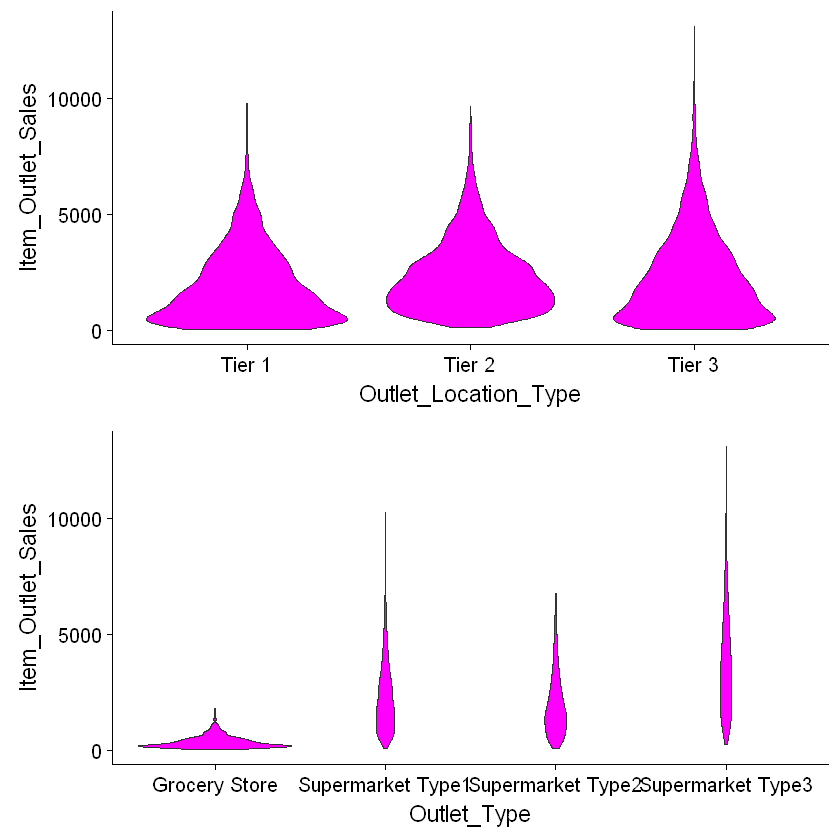

In [17]:
ggplot(train) + geom_violin(aes(Outlet_Size, Item_Outlet_Sales), fill = "magenta")

p15 = ggplot(train) + geom_violin(aes(Outlet_Location_Type, Item_Outlet_Sales), fill = "magenta")

p16 = ggplot(train) + geom_violin(aes(Outlet_Type, Item_Outlet_Sales), fill = "magenta")

plot_grid(p15, p16, ncol = 1)

## Missing Value Treatment

In [18]:
missing_index = which(is.na(combi$Item_Weight))
for(i in missing_index){
  
  item = combi$Item_Identifier[i]
  combi$Item_Weight[i] = mean(combi$Item_Weight[combi$Item_Identifier == item], na.rm = T)
  
}

# replacing 0 in Item_Visibility with mean
zero_index = which(combi$Item_Visibility == 0)
for(i in zero_index){
  
  item = combi$Item_Identifier[i]
  combi$Item_Visibility[i] = mean(combi$Item_Visibility[combi$Item_Identifier == item], na.rm = T)
  
}

## Feature Engineering

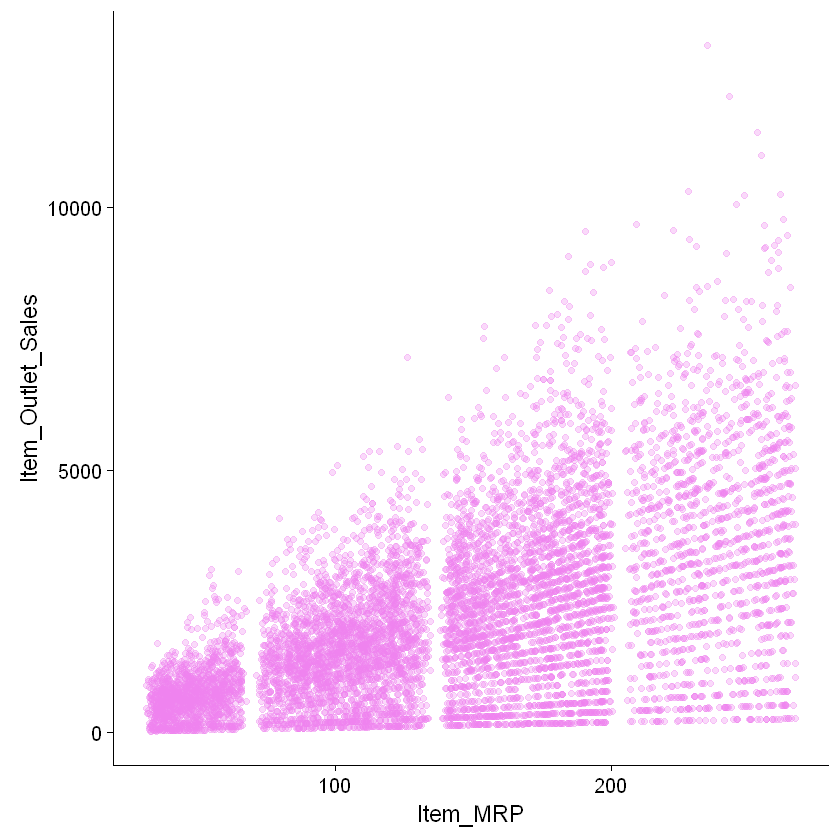

In [19]:
# create a new feature 'Item_Type_new' 
perishable = c("Breads", "Breakfast", "Dairy", "Fruits and Vegetables", "Meat", "Seafood")
non_perishable = c("Baking Goods", "Canned", "Frozen Foods", "Hard Drinks", "Health and Hygiene",
                   "Household", "Soft Drinks")

combi[,Item_Type_new := ifelse(Item_Type %in% perishable, "perishable",
                               ifelse(Item_Type %in% non_perishable, "non_perishable", "not_sure"))]


combi[,Item_category := substr(combi$Item_Identifier, 1, 2)]

combi$Item_Fat_Content[combi$Item_category == "NC"] = "Non-Edible"

# years of operation of outlets
combi[,Outlet_Years := 2013 - Outlet_Establishment_Year]
combi$Outlet_Establishment_Year = as.factor(combi$Outlet_Establishment_Year)

# Price per unit weight
combi[,price_per_unit_wt := Item_MRP/Item_Weight]


ggplot(train) + geom_point(aes(Item_MRP, Item_Outlet_Sales), colour = "violet", alpha = 0.3)

# creating new independent variable - Item_MRP_clusters
combi[,Item_MRP_clusters := ifelse(Item_MRP < 69, "1st", 
                                   ifelse(Item_MRP >= 69 & Item_MRP < 136, "2nd",
                                          ifelse(Item_MRP >= 136 & Item_MRP < 203, "3rd", "4th")))]

## Label Encoding

In [20]:
combi[,Outlet_Size_num := ifelse(Outlet_Size == "Small", 0,
                                 ifelse(Outlet_Size == "Medium", 1, 2))]

combi[,Outlet_Location_Type_num := ifelse(Outlet_Location_Type == "Tier 3", 0,
                                          ifelse(Outlet_Location_Type == "Tier 2", 1, 2))]

# removing categorical variables after label encoding
combi[, c("Outlet_Size", "Outlet_Location_Type") := NULL]

#### One Hot Encoding

In [23]:
ohe = dummyVars("~.", data = combi[,-c("Item_Identifier", "Outlet_Establishment_Year", "Item_Type")], fullRank = T)
ohe_df = data.table(predict(ohe, combi[,-c("Item_Identifier", "Outlet_Establishment_Year", "Item_Type")]))

combi = cbind(combi[,"Item_Identifier"], ohe_df)

Warning message in `[.data.table`(combi, , -c("Item_Identifier", "Outlet_Establishment_Year", :
"column(s) not removed because not found: Outlet_Establishment_Year,Item_Type"Warning message in `[.data.table`(combi, , -c("Item_Identifier", "Outlet_Establishment_Year", :
"column(s) not removed because not found: Outlet_Establishment_Year,Item_Type"

#### Remove skewness

In [24]:
combi[,Item_Visibility := log(Item_Visibility + 1)] # log + 1 to avoid division by zero
combi[,price_per_unit_wt := log(price_per_unit_wt + 1)]

#### Scaling and Centering data

In [25]:
num_vars = which(sapply(combi, is.numeric)) # index of numeric features
num_vars_names = names(num_vars)

combi_numeric = combi[,setdiff(num_vars_names, "Item_Outlet_Sales"), with = F]

prep_num = preProcess(combi_numeric, method=c("center", "scale"))
combi_numeric_norm = predict(prep_num, combi_numeric)

In [26]:
combi[,setdiff(num_vars_names, "Item_Outlet_Sales") := NULL] # removing numeric independent variables
combi = cbind(combi, combi_numeric_norm)

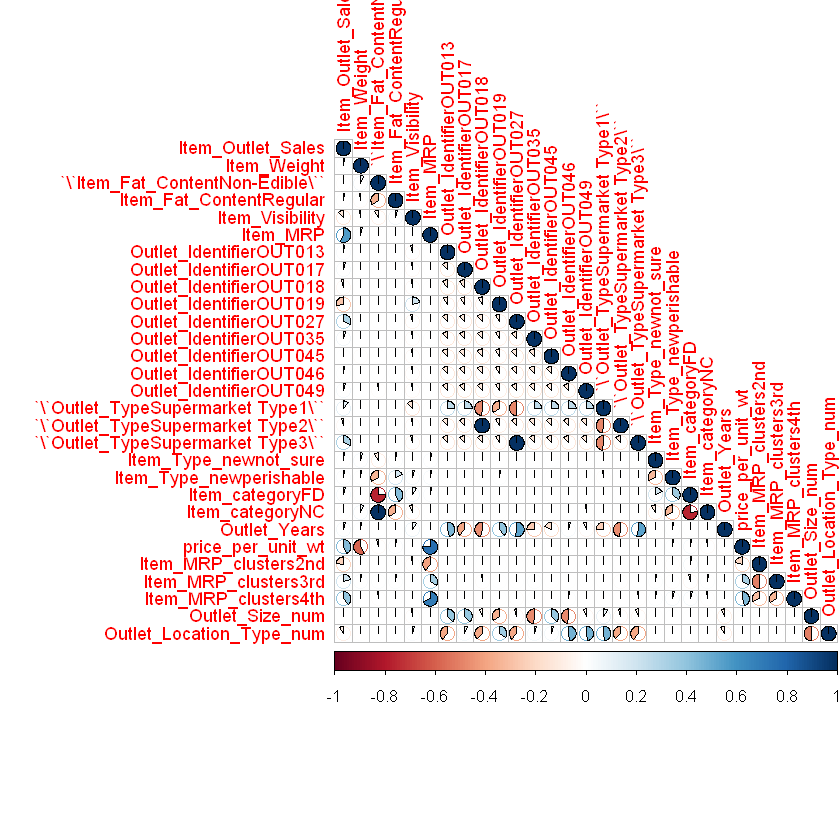

In [27]:
## splitting data back to train and test
train = combi[1:nrow(train)]
test = combi[(nrow(train) + 1):nrow(combi)]
test[,Item_Outlet_Sales := NULL] # removing Item_Outlet_Sales as it contains only NA for test dataset

## Correlation Plot
cor_train = cor(train[,-c("Item_Identifier")])

corrplot(cor_train, method = "pie", type = "lower", tl.cex = 0.9)

## Model Building:

### Model1: Linear Regression

In [29]:

linear_reg_mod = lm(Item_Outlet_Sales ~ ., data = train[,-c("Item_Identifier")])

## predicting on test set and writing a submission file
submission$Item_Outlet_Sales = predict(linear_reg_mod, test[,-c("Item_Identifier")])
write.csv(submission, "Linear_Reg_submit.csv", row.names = F)


Warning message in predict.lm(linear_reg_mod, test[, -c("Item_Identifier")]):
"prediction from a rank-deficient fit may be misleading"

### Model2: Lasso Regression

In [30]:
set.seed(1235)
my_control = trainControl(method="cv", number=5)
Grid = expand.grid(alpha = 1, lambda = seq(0.001,0.1,by = 0.0002))

lasso_linear_reg_mod = train(x = train[, -c("Item_Identifier", "Item_Outlet_Sales")], y = train$Item_Outlet_Sales,
                       method='glmnet', trControl= my_control, tuneGrid = Grid)

# mean validation score
mean(lasso_linear_reg_mod$resample$RMSE)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



[1] 1130.019

### Model3: Ridge Regression

In [31]:
set.seed(1236)
my_control = trainControl(method="cv", number=5)
Grid = expand.grid(alpha = 0, lambda = seq(0.001,0.1,by = 0.0002))

ridge_linear_reg_mod = train(x = train[, -c("Item_Identifier", "Item_Outlet_Sales")], y = train$Item_Outlet_Sales,
                       method='glmnet', trControl= my_control, tuneGrid = Grid)

# mean validation score
mean(ridge_linear_reg_mod$resample$RMSE)


[1] 1135.085

### Model4: RandomForest Model

In [32]:
# install.packages('ranger', repos='http://cran.us.r-project.org')
library(ranger)

Warning message:
"package 'ranger' was built under R version 3.4.4"

In [34]:
## List of parameters for XGBoost modeling
param_list = list(
        
        objective = "reg:linear",
        eta=0.01,
        gamma = 1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.5
        )

In [35]:
## converting train and test into xgb.DMatrix format
dtrain = xgb.DMatrix(data = as.matrix(train[,-c("Item_Identifier", "Item_Outlet_Sales")]), label= train$Item_Outlet_Sales)
dtest = xgb.DMatrix(data = as.matrix(test[,-c("Item_Identifier")]))


In [36]:
## 5-fold cross-validation to find optimal value of nrounds
set.seed(112)
xgbcv = xgb.cv(params = param_list, 
               data = dtrain, 
               nrounds = 1000, 
               nfold = 5, 
               print_every_n = 10, 
               early_stopping_rounds = 30, 
               maximize = F)

[1]	train-rmse:2746.725586+7.336395	test-rmse:2746.741797+30.998116 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 30 rounds.

[11]	train-rmse:2537.260938+5.858499	test-rmse:2539.031055+31.050055 
[21]	train-rmse:2349.231885+4.482735	test-rmse:2352.873389+32.255671 
[31]	train-rmse:2182.393750+4.819384	test-rmse:2187.824902+31.588163 
[41]	train-rmse:2033.432080+3.195964	test-rmse:2040.415454+31.588752 
[51]	train-rmse:1900.760058+2.740688	test-rmse:1910.174609+30.442020 
[61]	train-rmse:1784.256690+2.877070	test-rmse:1796.284033+28.750707 
[71]	train-rmse:1680.479932+2.497050	test-rmse:1695.349048+28.331918 
[81]	train-rmse:1590.351367+2.354304	test-rmse:1607.833301+27.908130 
[91]	train-rmse:1510.894165+2.035948	test-rmse:1531.593726+27.522115 
[101]	train-rmse:1441.319312+1.659380	test-rmse:1465.053589+29.087921 
[111]	train-rmse:1381.578052+2.426386	test-rmse:1408.426611+27.691651 
[121]	train-rmse:1329.56550

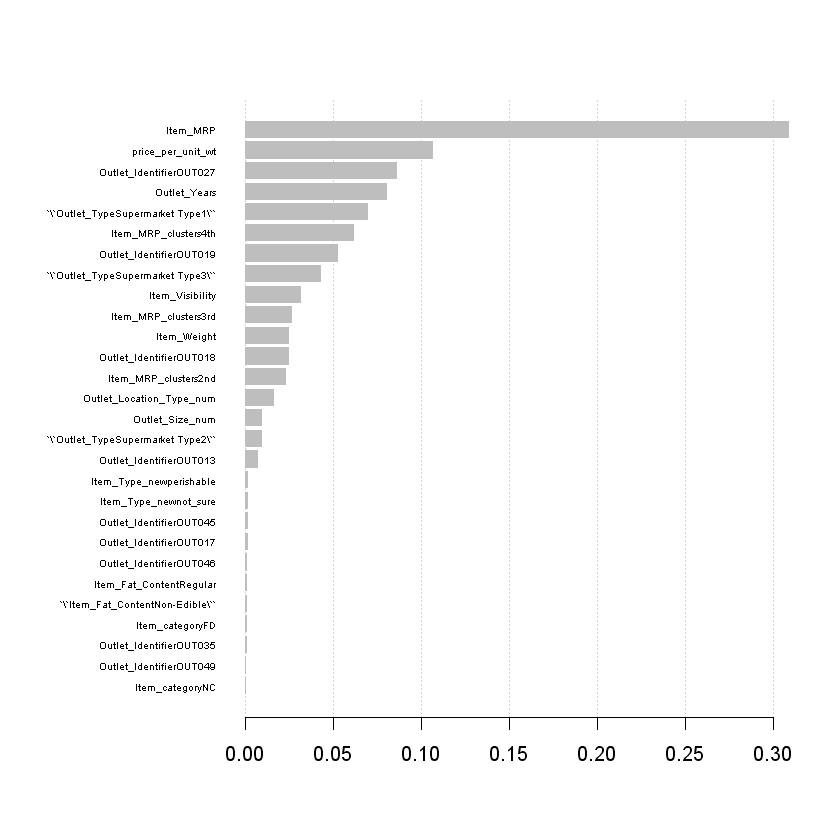

In [37]:
## training XGBoost model at nrounds = 430
xgb_model = xgb.train(data = dtrain, params = param_list, nrounds = 430)

## Variable Importance
var_imp = xgb.importance(feature_names = setdiff(names(train), c("Item_Identifier", "Item_Outlet_Sales")), 
                         model = xgb_model)

xgb.plot.importance(var_imp)

